# Mispronunciation Detection & Diagnosis

Use pre-trained Wav2Vec2 and Espeak to extract phoneme sequences from recorded speech and reference text, respectively. The extracted sequences are then aligned using the Needleman-Wunsch algorithm, and a Large Language Model (LLM) is used to generate feedback on mispronunciations.

Key Features:
- Utilizes Wav2Vec2 for speech-to-phoneme conversion
- Employs Espeak for reference phoneme sequence generation
- Implements Needleman-Wunsch algorithm for alignment
- Integrates LLM for personalized feedback

# Sample Feedback from Large Language Model (LLM)
The LLM provides personalized feedback on mispronunciations, suggesting corrections and improvements.   
Here's an example of what the feedback might look like:

**Overall Impression:** Your pronunciation is good, but there are some areas that need attention to sound more natural in American English.

**Specific Feedback:**

1. **('early', 'ɜːli', 'ʌrliː')**: Your pronunciation of "early" is close, but the vowel sound is a bit off. Try to pronounce it more like "UR-lee" (ʌrˈliː) with a more relaxed, open vowel sound.
2. **('bird', 'bɜːd', 'boʊd')**: You're pronouncing "bird" more like "board." Try to pronounce it with a shorter "i" sound, more like "BURD" (bɜːrd).
3. **('catches', 'kæ_tʃᵻz', 'kæntʃɪz')**: Your pronunciation of "catches" is close, but the "tch" sound is a bit off. Try to pronounce it more like "KAY-chiz" (kætʃɪz) with a sharper "tch" sound.
4. **('worm', 'wɜːm', 'woːm')**: You're pronouncing "worm" more like "warm." Try to pronounce it with a shorter "o" sound, more like "WURM" (wɜːrm).
5. **('mouse', 'maʊs', 'maʊ_z')**: Your pronunciation of "mouse" is close, but the "s" sound is a bit off. Try to pronounce it more like "MAW-s" (maʊs) with a clearer "s" sound.

**Google Pronunciation Respelling Suggestions:**

* early: UR-lee (ʌrˈliː)
* bird: BURD (bɜːrd)
* catches: KAY-chiz (kætʃɪz)
* worm: WURM (wɜːrm)
* mouse: MAW-s (maʊs)

**Additional Tips:**

* Pay attention to your vowel sounds, especially in words like "early" and "bird."
* Work on pronouncing the "tch" sound in words like "catches" more sharply.
* Focus on the rhythm and intonation of the sentence to sound more natural in American English.

I hope this feedback helps you improve your American accent!

In [ ]:
#pip install pyaudio
#brew install egspeak
#pip install phonemizer
#pip install python-Levenshtein
#pip install requests ipywidgets sounddevice soundfile
#pip install sequence_align

In [ ]:
import dotenv

import json
import os
import pyaudio
import wave
import base64
import requests
import io
import re

dotenv.load_dotenv()

# HF INFERENCE API
API_TOKEN = os.environ.get("HF_API_TOKEN") #https://huggingface.co/settings/profile
headers = {"Authorization": f"Bearer {API_TOKEN}"}

PHONEME_API_URL = "https://api-inference.huggingface.co/models/mrrubino/wav2vec2-large-xlsr-53-l2-arctic-phoneme" # "https://api-inference.huggingface.co/facebook/wav2vec2-xlsr-53-phon-cv-ft"
STT_API_URL = "https://api-inference.huggingface.co/models/openai/whisper-small"

def query(filename, API_URL):
    with open(filename, "rb") as f:
        data = f.read()
    response = requests.request("POST", API_URL, headers=headers, data=data, json={"options": {"wait_for_model": True, "return_timestamps":True}})
    return json.loads(response.content.decode("utf-8"))


In [ ]:
import ipywidgets as widgets
from IPython.display import display, Audio, HTML, Markdown

import sounddevice as sd
import soundfile as sf

# Define a function to record audio when the button is clicked
def record_audio(b):
    with output:
        if b.description == 'Start Recording':
            b.description = 'Stop Recording'
            print('Recording...')
            fs = 44100  # sample rate
            seconds = 10  # recording duration
            myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2)
            sd.wait()
            sf.write('output.wav', myrecording, fs)
            print('Recording saved as output.wav')
        else:
            b.description = 'Start Recording'

In [ ]:
import random

# Reference text that the user is prompted to read out loud. 
sentences = [
    "The red boat sailed across the wide blue ocean.",
    "Mary had a little lamb, its fleece was white as snow.",
    "Can you imagine a world without books and stories?",
    "The early bird catches the worm, but the second mouse gets the cheese.",
    "The car swerved to avoid the squirrel running across the road.",
    "She sells seashells by the seashore.",
    "Peter Piper picked a peck of pickled peppers.",
    "A stitch in time saves nine.",
    "The boat sailed smoothly over the calm water yesterday."
]
reference_text = random.choice(sentences)
reference_text

## Record Audio

Record audio of the user reading out loud a given reference text

In [ ]:
# Create a button to start and stop recording
print(f'Read out loud - "{reference_text}"')
button = widgets.Button(description='Start Recording')
display(button)

# Create an output widget to display the recorded audio
output = widgets.Output()
display(output)

# Link the function to the button
button.on_click(record_audio)

In [ ]:
# Display the audio player widget
Audio('output.wav')

# Get recorded phoneme sequence

This step involves converting the recorded speech into a phoneme sequence using a fine-tuned version of the wav2vec2 model. Specifically, we are utilizing the **wav2vec2-xlsr-53-phon-cv-ft** model, which has been fine-tuned on the Common Voice dataset comprising 53 different languages.

Here's how it works:

1. **Input Audio**: Provide an input audio file containing the recorded speech.
Phoneme Sequence Generation: The fine-tuned wav2vec2 model processes the input audio and generates a phoneme sequence representing the spoken sounds in the recording.

2. The **wav2vec2-xlsr-53-phon-cv-ft** model is a pre-trained language model that has been fine-tuned on a large dataset of spoken languages. This fine-tuning enables the model to learn the patterns and characteristics of spoken languages, allowing it to accurately generate phoneme sequences from input audio.
By using this model, we can extract the phoneme sequence from the recorded speech, which is essential for further processing and analysis in our pipeline.

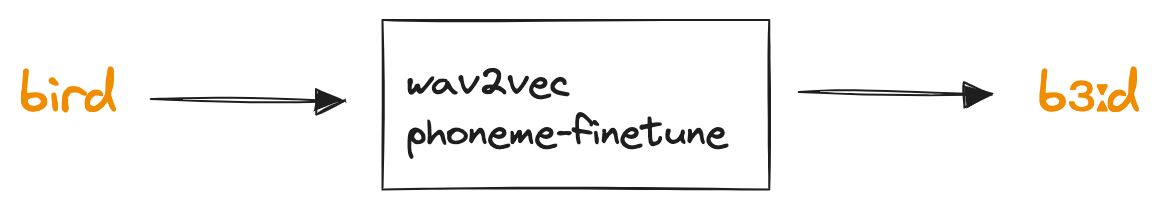

You have two options for using a pre-trained Wav2Vec2 model:

- Hugging Face Hub: You can use the facebook/wav2vec2-xlsr-53-phon-cv-ft model from the Hugging Face Hub. However, please note that I encountered issues with the Phonemeizer package, which is required for this model.

- Modallabs Deployment: To overcome the Phonemeizer issue, I deployed the model on Modallabs. The deployment code is available in this repository.

Alternative Model on Hugging Face: If you don't want to deploy a model, you can use the /mrrubino/wav2vec2-large-xlsr-53-l2-arctic-phoneme model on Hugging Face, which worked for me.

In [ ]:
MODAL_URL = "https://<>--phoneme-recognizer-dev.modal.run"

def get_phones(filepath):

    # # Load your audio file
    with open(filepath, "rb") as f:
        audio_data = f.read()

    # Encode the WAV data as base64 data url
    audio_base64 = base64.b64encode(audio_data).decode("utf-8")
    data_url = f"data:audio/wav;base64,{audio_base64}"

    # Prepare the request payload
    payload = {
        "audio": data_url 
    }
    # token = "d"
    headers = {"Authorization": f"Bearer {token}"}
    response = requests.post(
        MODAL_URL, json=payload,  headers=headers
    )
    
    # Check if the request was successful
    if response.status_code == 200:
        # print("request completed")
        transcription = response.json()
        return transcription
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return 

In [ ]:
# get recorded speech phoneme using deployed model
recorded_phoneme = get_phones('output.wav')['text']
recorded_phoneme

# or use HF hub model
# wait for the model to load
#print(query('output.wav', PHONEME_API_URL))
#recorded_phoneme = query('output.wav', PHONEME_API_URL)['text']

# Get Reference Phoneme sequence

Converts a given reference text into a phoneme representation, breaking down each word into its individual phonetic sounds, ignoring punctuation and word boundaries, and returns a lexicon of words with their corresponding phonemes. 

This process involves:
- Removing punctuation from the text
- Splitting the text into individual words
- Converting each word into its phonetic equivalent using the EspeakBackend engine
- Combining the phonemes into a comprehensive lexicon

In [ ]:
import phonemizer
from phonemizer.punctuation import Punctuation
from phonemizer.backend import EspeakBackend
from phonemizer.separator import Separator

def generate_reference_phoneme(reference_text):
    text = Punctuation(';:,.!"?()').remove(reference_text)
    ref_words = [w.lower() for w in text.strip().split(' ') if w]
    
    
    # initialize the espeak backend for English
    backend = EspeakBackend('en-us')
    
    # separate phones by a space and ignoring words boundaries
    separator = Separator(phone='', word=None)
    
    # build the lexicon by phonemizing each word one by one. The backend.phonemize
    # function expect a list as input and outputs a list.
    lexicon = [ (word, backend.phonemize([word], separator=separator, strip=True)[0])
        for word in ref_words]
    
    return lexicon, ref_words 

In [ ]:
lexicon, ref_words = generate_reference_phoneme(reference_text)
reference_phoneme =' '.join([phon for w, phon in lexicon])
reference_phoneme

# Align phoneme sequences

Perform sequence alignment between the reference phoneme sequence and the recorded phoneme sequence using the Needleman-Wunsch algorithm. The goal is to find the optimal alignment between the two sequences, allowing for insertions, deletions, and substitutions.

The Needleman-Wunsch algorithm is a dynamic programming algorithm used in bioinformatics and natural language processing for pairwise sequence alignment. It's a global alignment algorithm, meaning it aligns two entire sequences from start to end, finding the optimal alignment between them.


In [ ]:
#https://github.com/kensho-technologies/sequence_align
from sequence_align.pairwise import hirschberg, needleman_wunsch
seq_a = reference_phoneme
seq_b = list(recorded_phoneme.replace(' ',''))

# recorded_phoneme['text']
aligned_seq_a, aligned_seq_b = needleman_wunsch(
    seq_a,
    seq_b,
    match_score=1.0,
    mismatch_score=-1.0,
    indel_score=-1.0,
    gap="_",
)
aligned_reference_seq = ''.join(aligned_seq_a)
aligned_recorded_seq = ''.join(aligned_seq_b)

print('Reference Text: ', reference_text)
print('Reference Phoneme:',aligned_reference_seq)
print('Recorded Phoneme: ', aligned_recorded_seq)

# Split Phoneme sequences into words

Split the reference and recorded phoneme sequences into individual words and aligns them for comparison, allowing for accurate analysis of spoken audio against the original reference text.

In [ ]:
def find_word_start_positions(reference_sequence):
    # Split the sequence into words based on spaces
    words = reference_sequence.split()
    # Initialize a list to store the start positions
    start_positions = []
    # Initialize the current position
    current_position = 0
    # Iterate over the words
    for word in words:
        # Add the current position to the start positions list
        start_positions.append(current_position)
        # Increment the current position by the length of the word plus 1 (for the space)
        current_position += len(word) + 1
    return start_positions

def split_recorded_sequence(recorded_sequence, start_positions):
    # Initialize a list to store the split words
    split_words = []
    # Iterate over the start positions
    for i in range(len(start_positions)):
        # Get the start position
        start = start_positions[i]
        # If it's the last word, get the end position as the length of the sequence
        if i == len(start_positions) - 1:
            end = len(recorded_sequence)
        # Otherwise, get the end position as the start position of the next word
        else:
            end = start_positions[i + 1]
        # Extract the word from the recorded sequence
        word = recorded_sequence[start:end]
        # Add the word to the list
        split_words.append(word)
    return split_words
    
# recorded_sequence = "aɪ_hoːp_ðeɪ_hɛv_maɪ_fiːv__rədbrænd_aɪl_biː_bæk_su_n__tʊ_pliːz_w_iːdfoː__miː_"
ref_start_positions = find_word_start_positions(''.join(aligned_reference_seq))

# split recorded based on the reference start positions
rec_split_words = split_recorded_sequence(''.join(aligned_recorded_seq), ref_start_positions)
rec_split_words = [re.sub('( |\\_)$','',w) for w in rec_split_words]

# split ref based on the reference start positions
ref_split_words = split_recorded_sequence(''.join(aligned_reference_seq), ref_start_positions)
ref_split_words = [re.sub('(\\_| )$','',w) for w in ref_split_words]

# print('Reference Text: ',reference_text)
# print('(word, reference_phoneme, recorded_phoneme)',list(zip(ref_words, ref_split_words, rec_split_words)))
word_comparision_list = list(zip(ref_words, ref_split_words, rec_split_words))
word_comparision_list

# Color code differences in phonemes

In [ ]:
max_length = max(len(w) for w, _, _ in word_comparision_list)

for w, ref_w, rec_w in word_comparision_list:
    word = f"\033[1m{w}\033[0m".ljust(max_length)
    if ref_w == rec_w:
        rec_string = f"\033[92m{rec_w}\033[0m".ljust(max_length)  # Green color
    else:
        mismatch_index = 0
        for i, (c1, c2) in enumerate(zip(ref_w, rec_w)):
            if c1 != c2:
                mismatch_index = i
                break
        rec_string = "{}\033[91m{}\033[0m{}".format(rec_w[:mismatch_index], rec_w[mismatch_index], rec_w[mismatch_index+1:]).ljust(max_length)

    print(word, ref_w, rec_string)

# Use LLM to provide feedback based on the phoneme differences

Get api keys from https://console.groq.com/keys

In [ ]:
import os
from groq import Groq

client = Groq(
    api_key=os.environ.get("GROQ_API_KEY"),
)
system_message = """You are an expert dialect/accent coach for american spoken english. you will provide valuable feedback to improve my american accent. For ease of understanding, I would prefer you give suggestions for mipronunciation using google pronunciation respelling.
provide following Overall Impression, Specific Feedback, Google Pronunciation Respelling Suggestions, additional tips"""
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "system",
            "content": system_message
        },
        {
            "role": "user",
            "content": f"""Reference Text:  {reference_text}
(word, reference_phoneme, recorded_phoneme) 
{word_comparision_list}""",
        }
    ],
    model="llama3-70b-8192",
    temperature=0
)

feedback = chat_completion.choices[0].message.content
display(Markdown(feedback))